# Playground for benchmark data and plotting

In [1]:
# import external dependencies
import pandas as pd
import seaborn as sb
import seaborn.objects as so
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from pathlib import PosixPath

from picasso import folder_selection
from lib.stats import Vmstat, Mpstat, CpuIO, DiskIO, DockerStats, Tootbench, Ping
import lib.filter as filter
import lib.window as window


In [2]:
sb.set_style("whitegrid")
sb.set_context("talk")
#sb.set_palette(sb.crayons)

In [3]:
folder = PosixPath("input/2023-02-07T05:34:39_6core-6GB_25sidekiq_5.5s_interval_20min")
folder


PosixPath('input/2023-02-07T05:34:39_6core-6GB_25sidekiq_5.5s_interval_20min')

## Mastodon instance CPU utilization (vmstat)

In [4]:
vm = Vmstat(folder, False)

initializing vmstat
initialized. vmstat


39828
7977
showing new plot: vmstat-cpu-sum_mastodon


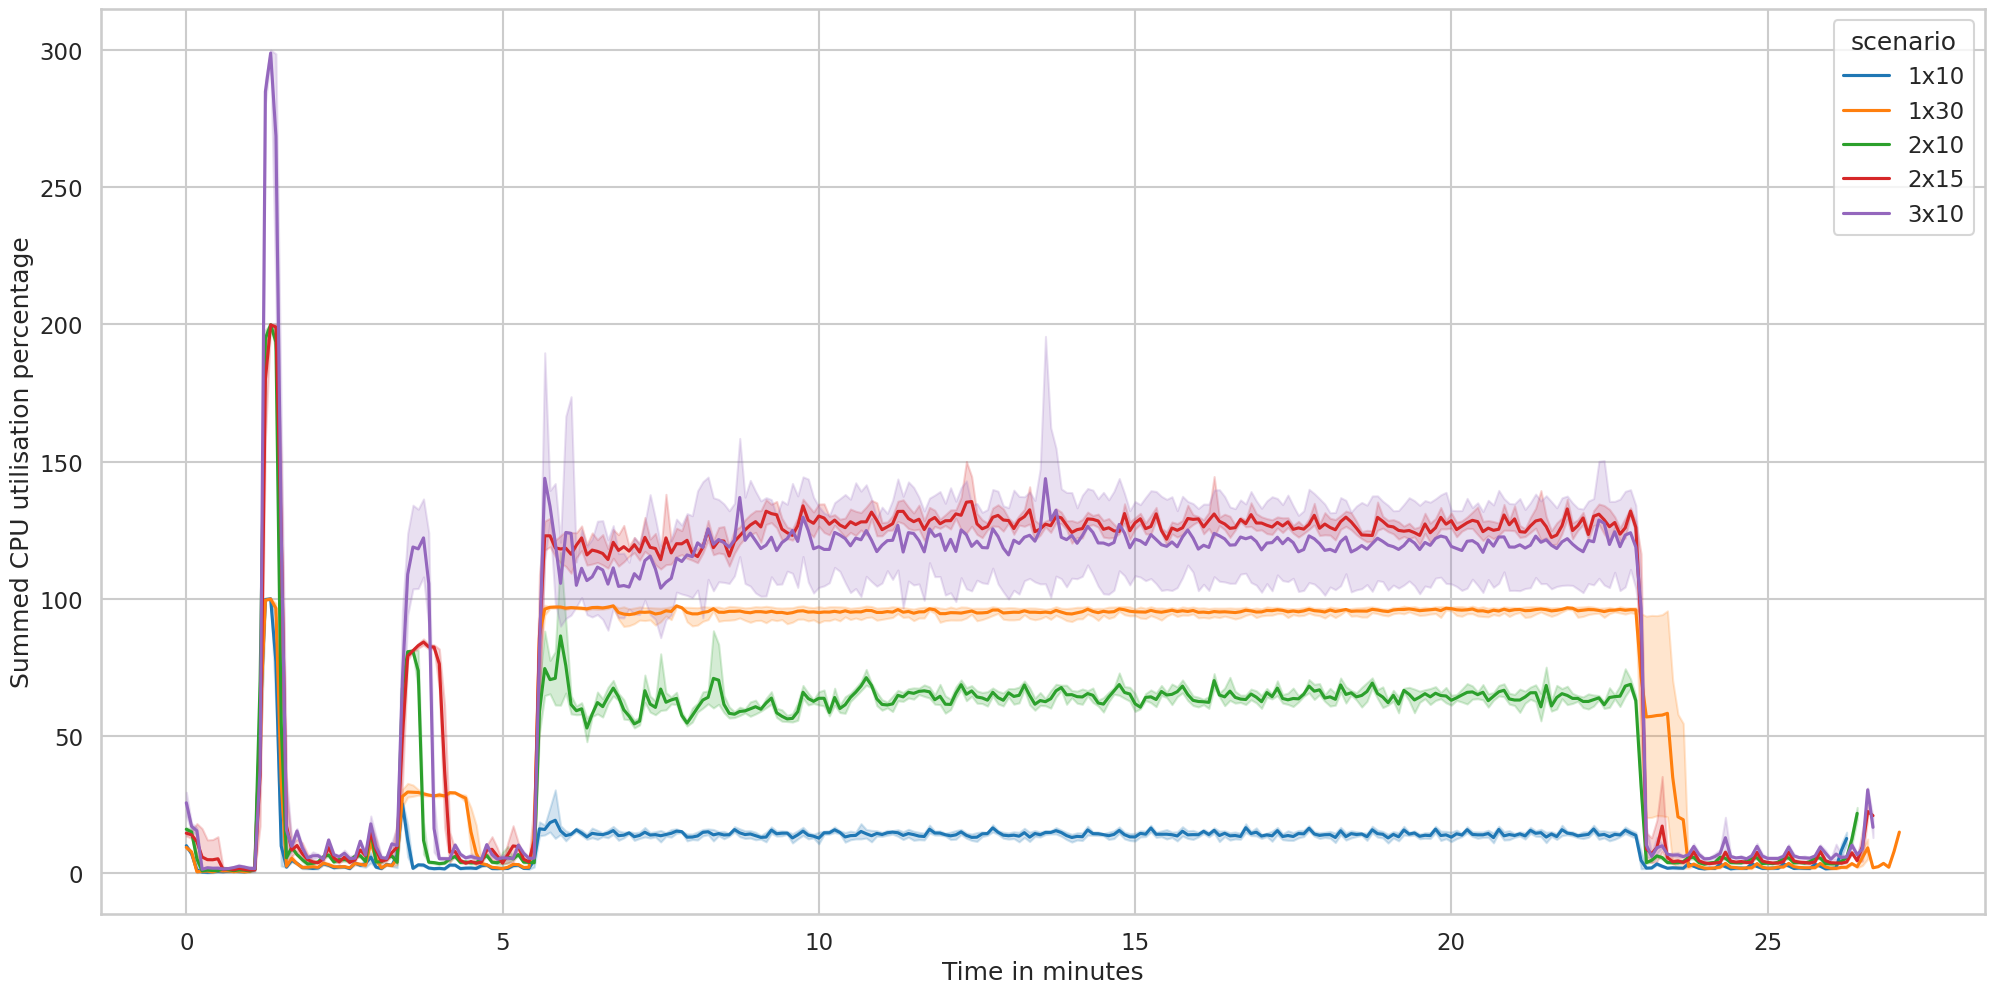

In [5]:
vm.cpu_sum(window.tumble(["scenario", "run"]))

71734


14372
showing new plot: vmstat-cpu-utilization_windowed


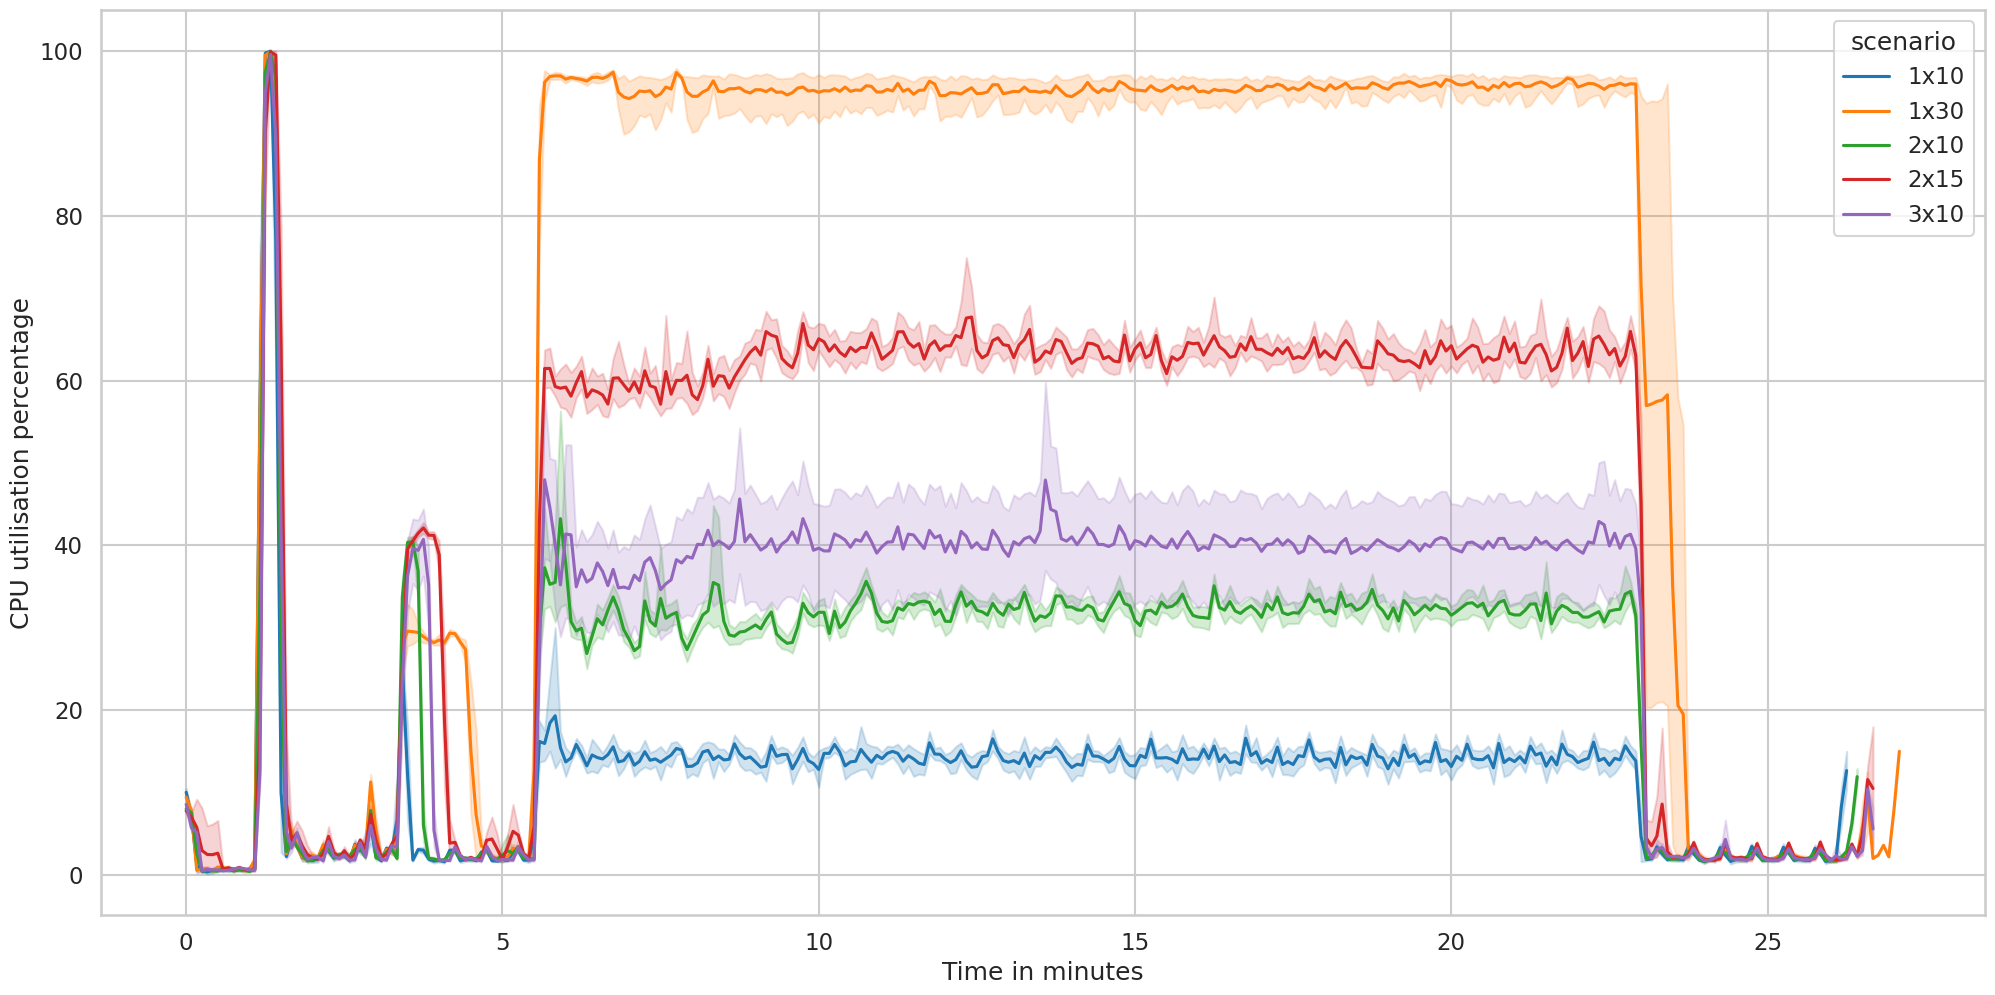

showing new plot: vmstat-kernel-utilization_windowed


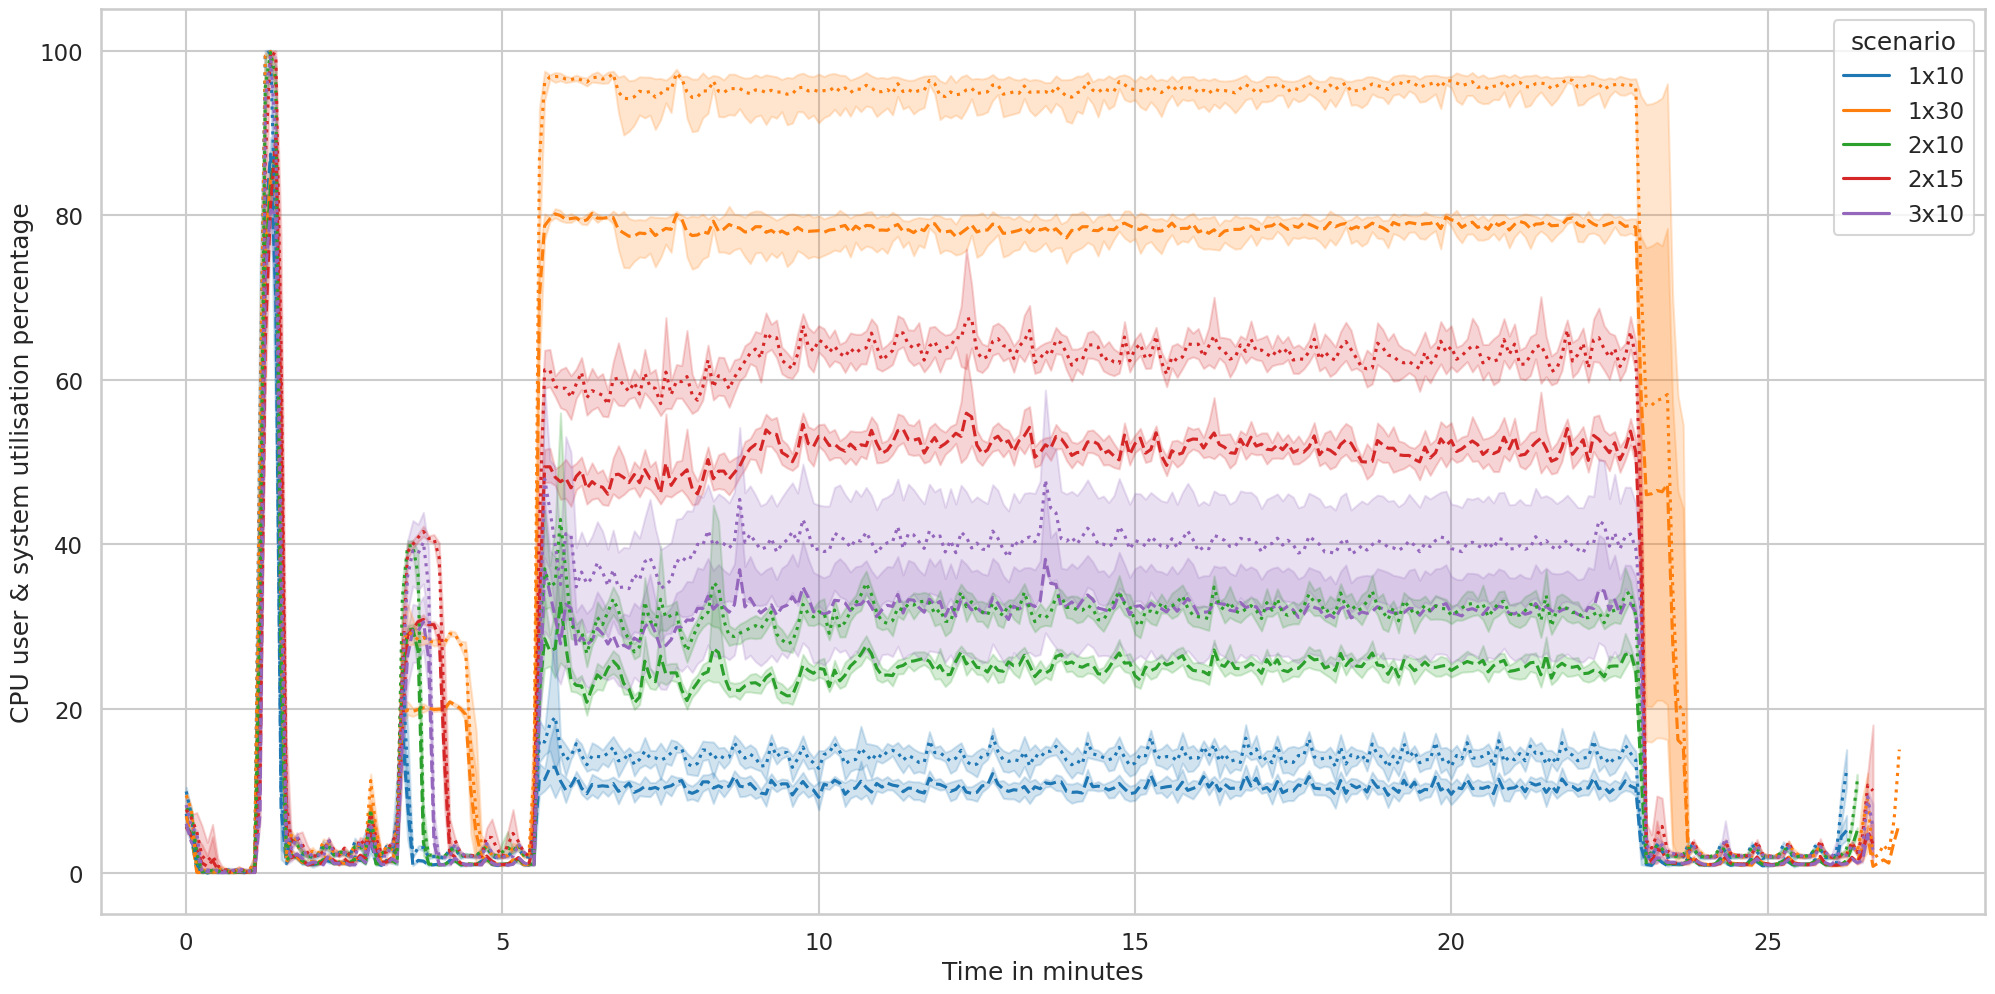

In [6]:
# cpu utilization of the machines hosting the mastodon stack
# second image includes cpu user utilization (lower/bold line of same color)
vm.cpu_utilization(filter.of(filter.instances, window.tumble()), "windowed")

## Client instance CPU utilization (vmstat)

39817
7975


showing new plot: vmstat-cpu-utilization_windowed_client


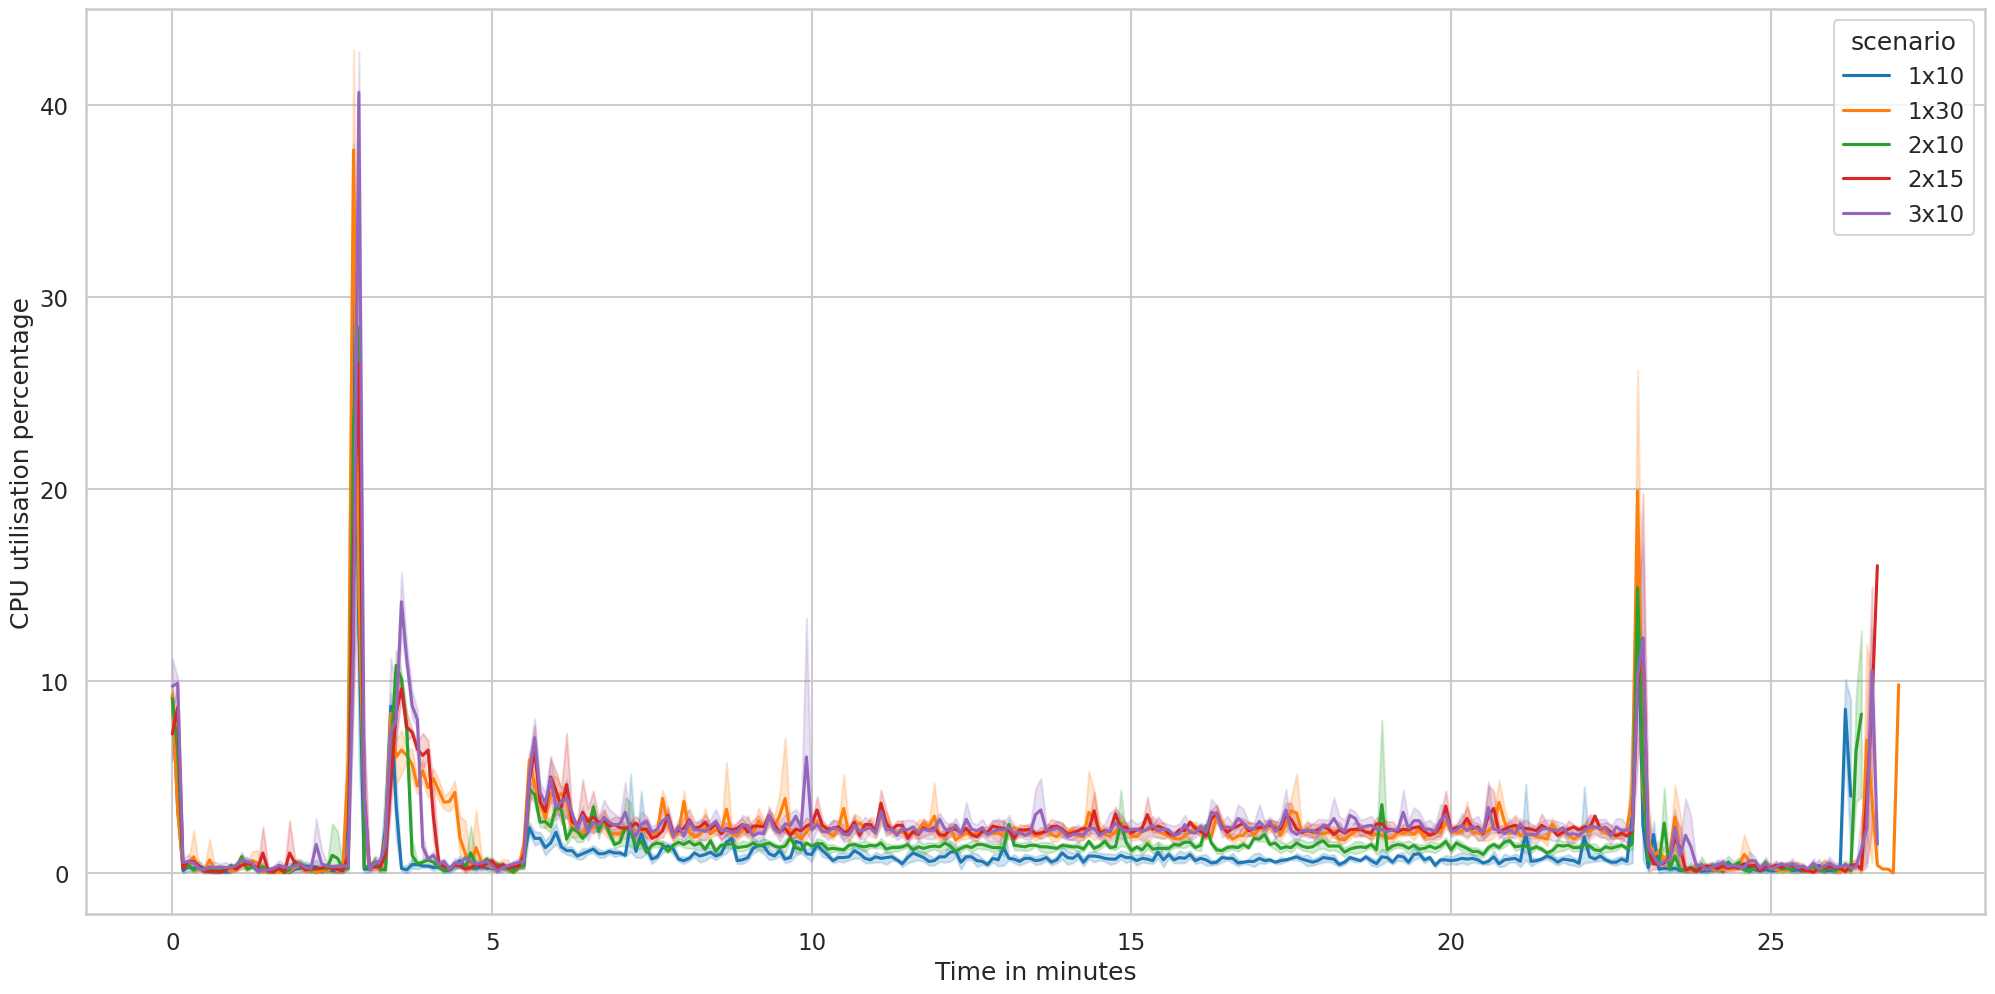

showing new plot: vmstat-kernel-utilization_windowed_client


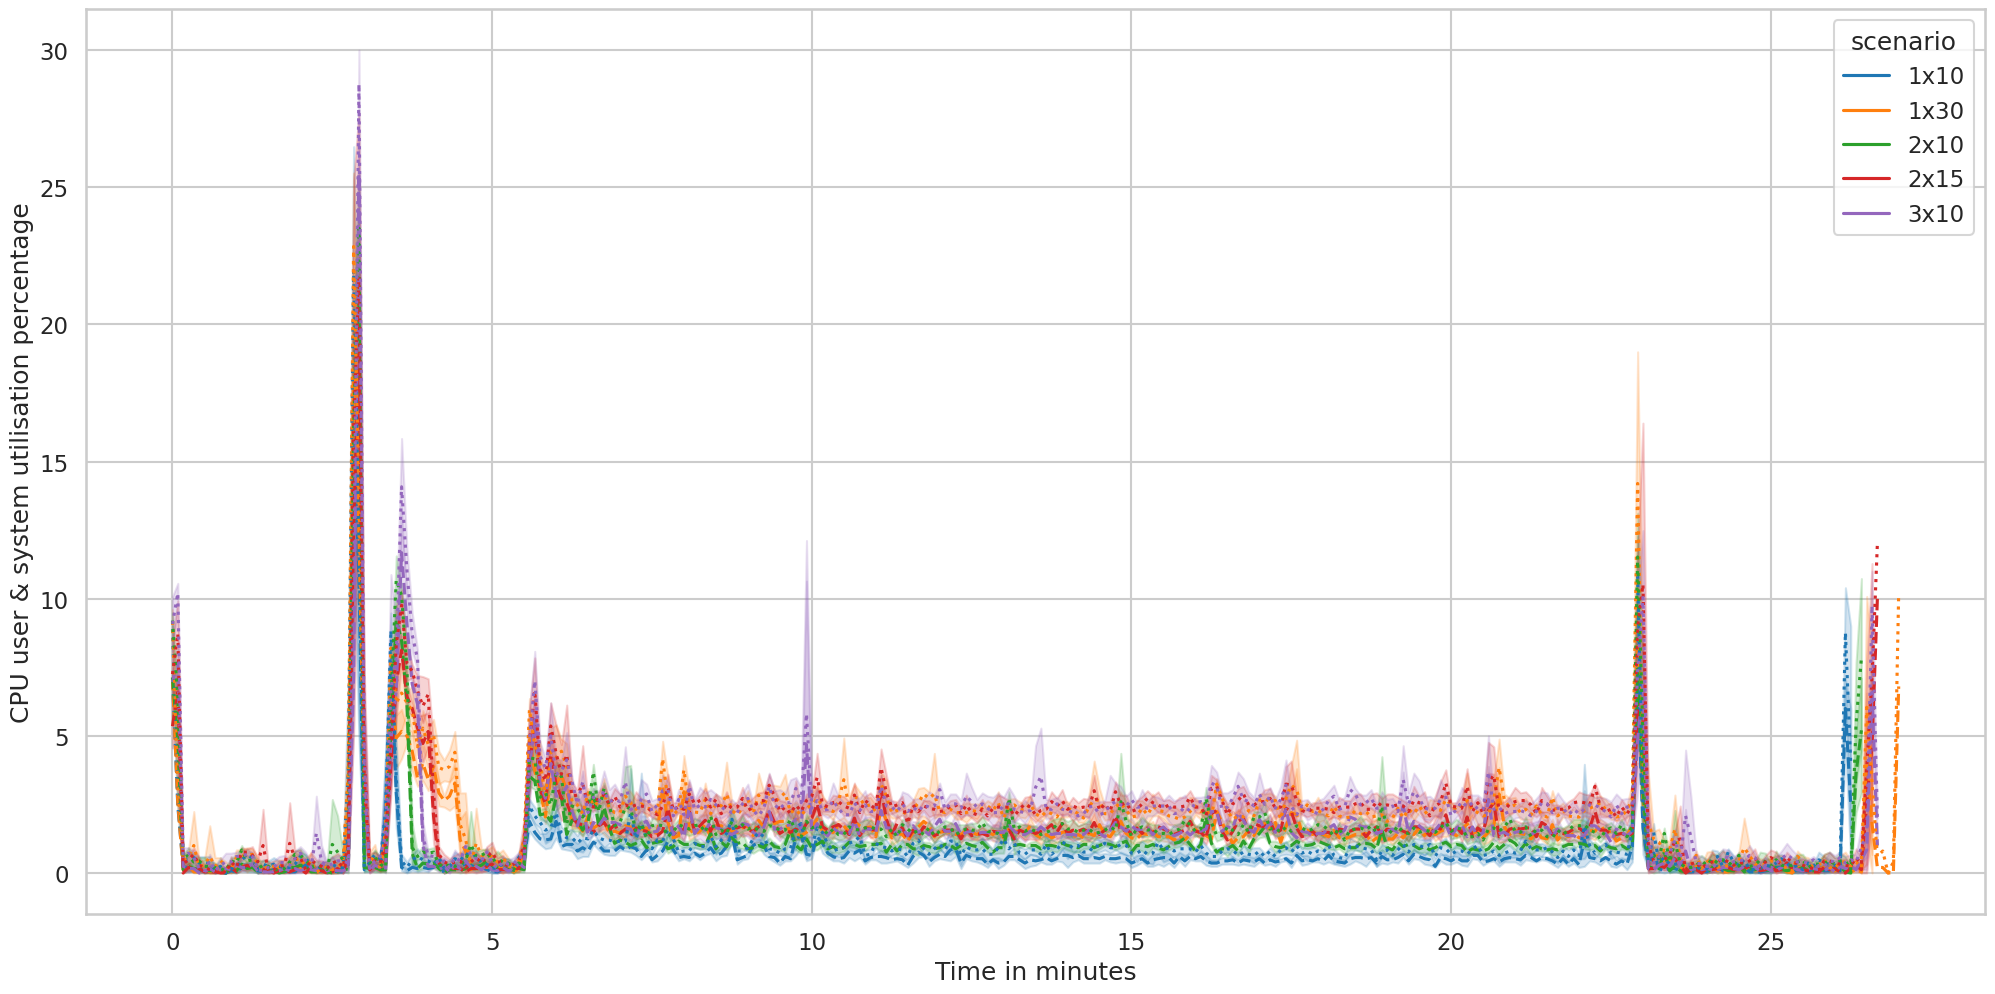

In [7]:
# CPU utilization of the machine hosting the client application during the scenarios
vm.cpu_utilization(filter.of(filter.client, window.tumble()), "windowed_client")

## Mastodon memory consumption

Sum of all containers of the stack of all instances in the given scenario.

Scenarios with more instances, consume more memory globally, even though there are the same number of users globally.
To compare: purple, red and orange - scenarios with 30 global users each but different amount of instances. Global memory consumption differes greatly.

In [8]:
docker = DockerStats(folder, False)

initializing docker-stats
initialized. docker-stats


71573
14330


showing new plot: docker_mem_sum_all_mastodon


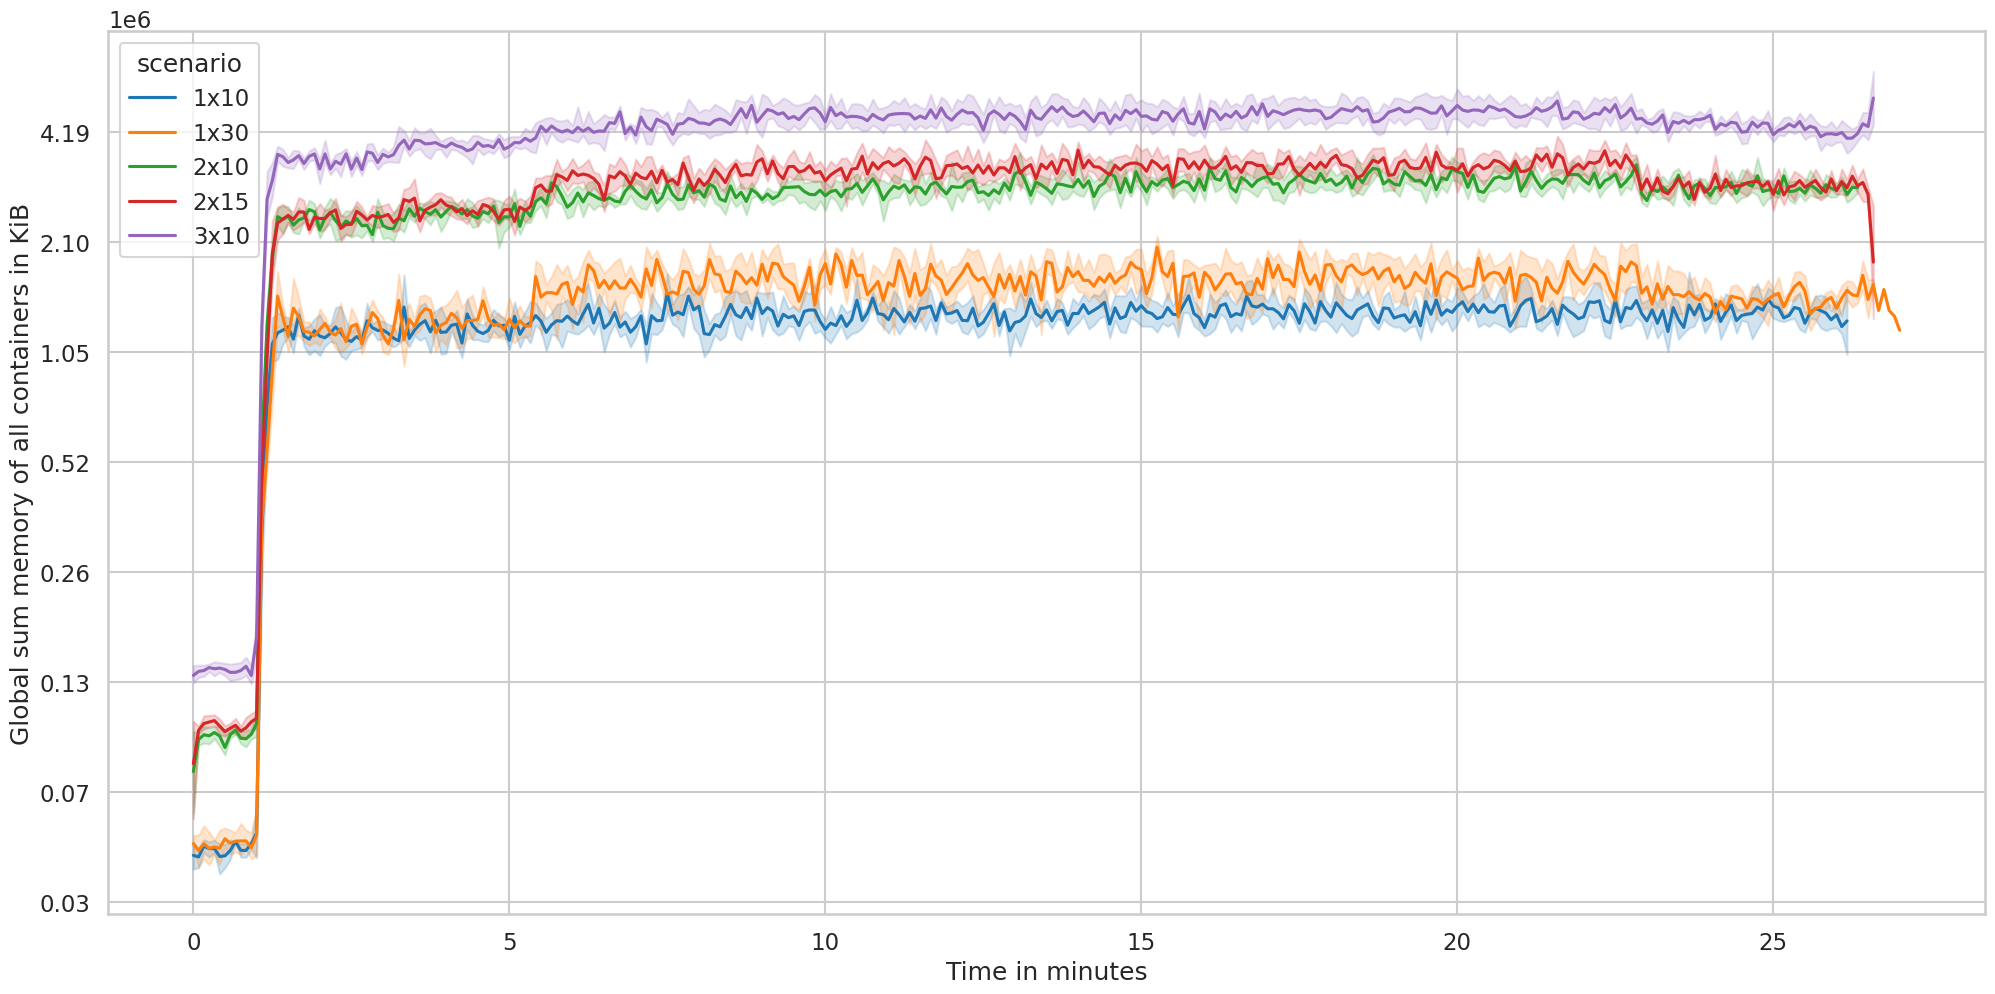

In [10]:
docker.mem_sum(window.tumble())

## Ping latency between machines

Maximum latency of each second during the experiments. Includes all scenarios.

In [11]:
ping = Ping(folder,False)

initializing ping
initialized. ping


219060
44798
0        1675804416
1        1675804416
2        1675806259
3        1675806259
4        1675808083
            ...    
44793    1675802128
44794    1675802133
44795    1675802133
44796    1675802135
44797    1675802135
Name: timestamp, Length: 44798, dtype: int64
showing new plot: ping_mastodon


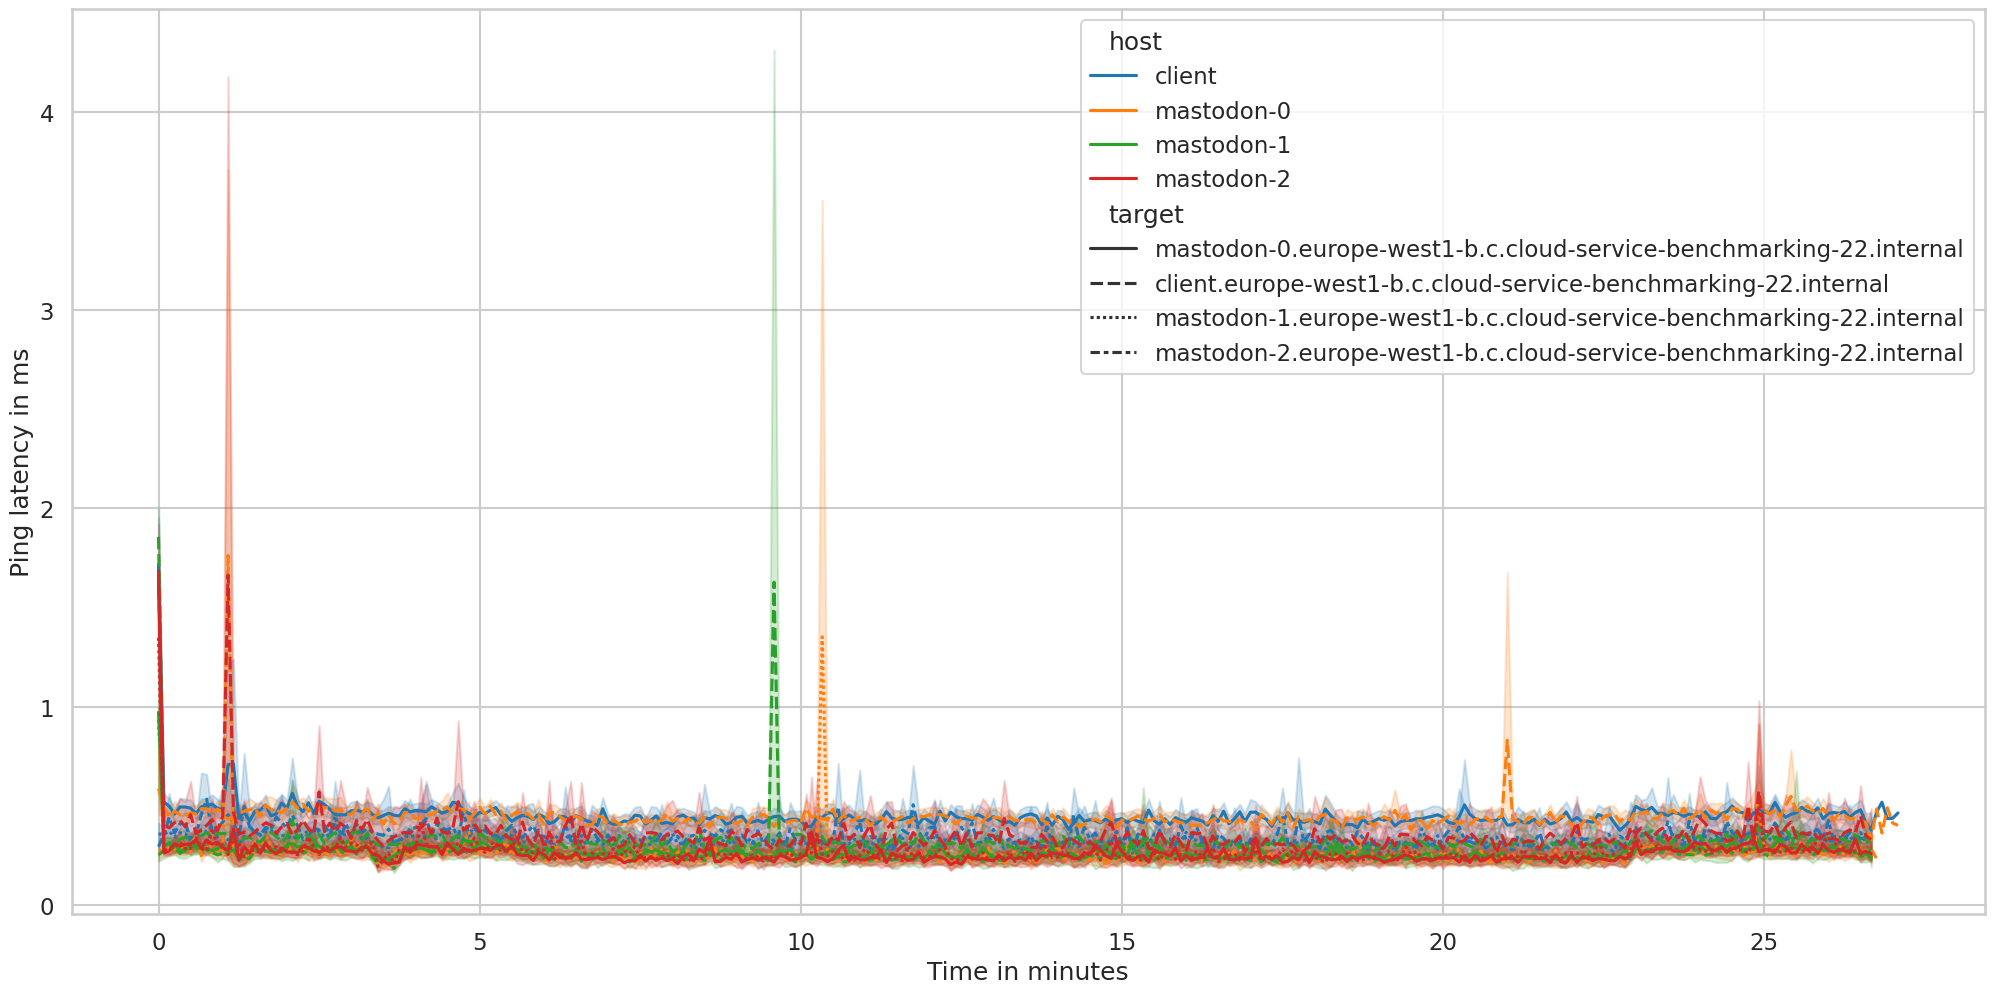

In [12]:
ping.lineplot(window.tumble(["scenario", "run", "host", "target", "ip"], func=window.max))

## Mastodon post message latency

Latency of message transmissions.

tx: client creates a new toot (time from request until server received timestamp)
rx: time between server received toot until receiver can see toot in their timeline
txack: time between client request until receiving the servers response

In [15]:
client_data_window = window.tumble(["scenario", "run", "message_type", "same_host"], time_column="time_delta", unit="m")

In [13]:
toot = Tootbench(folder, False)

initializing tootbench
initialized. tootbench


2986824


13662
showing new plot: client_post_tx_latency


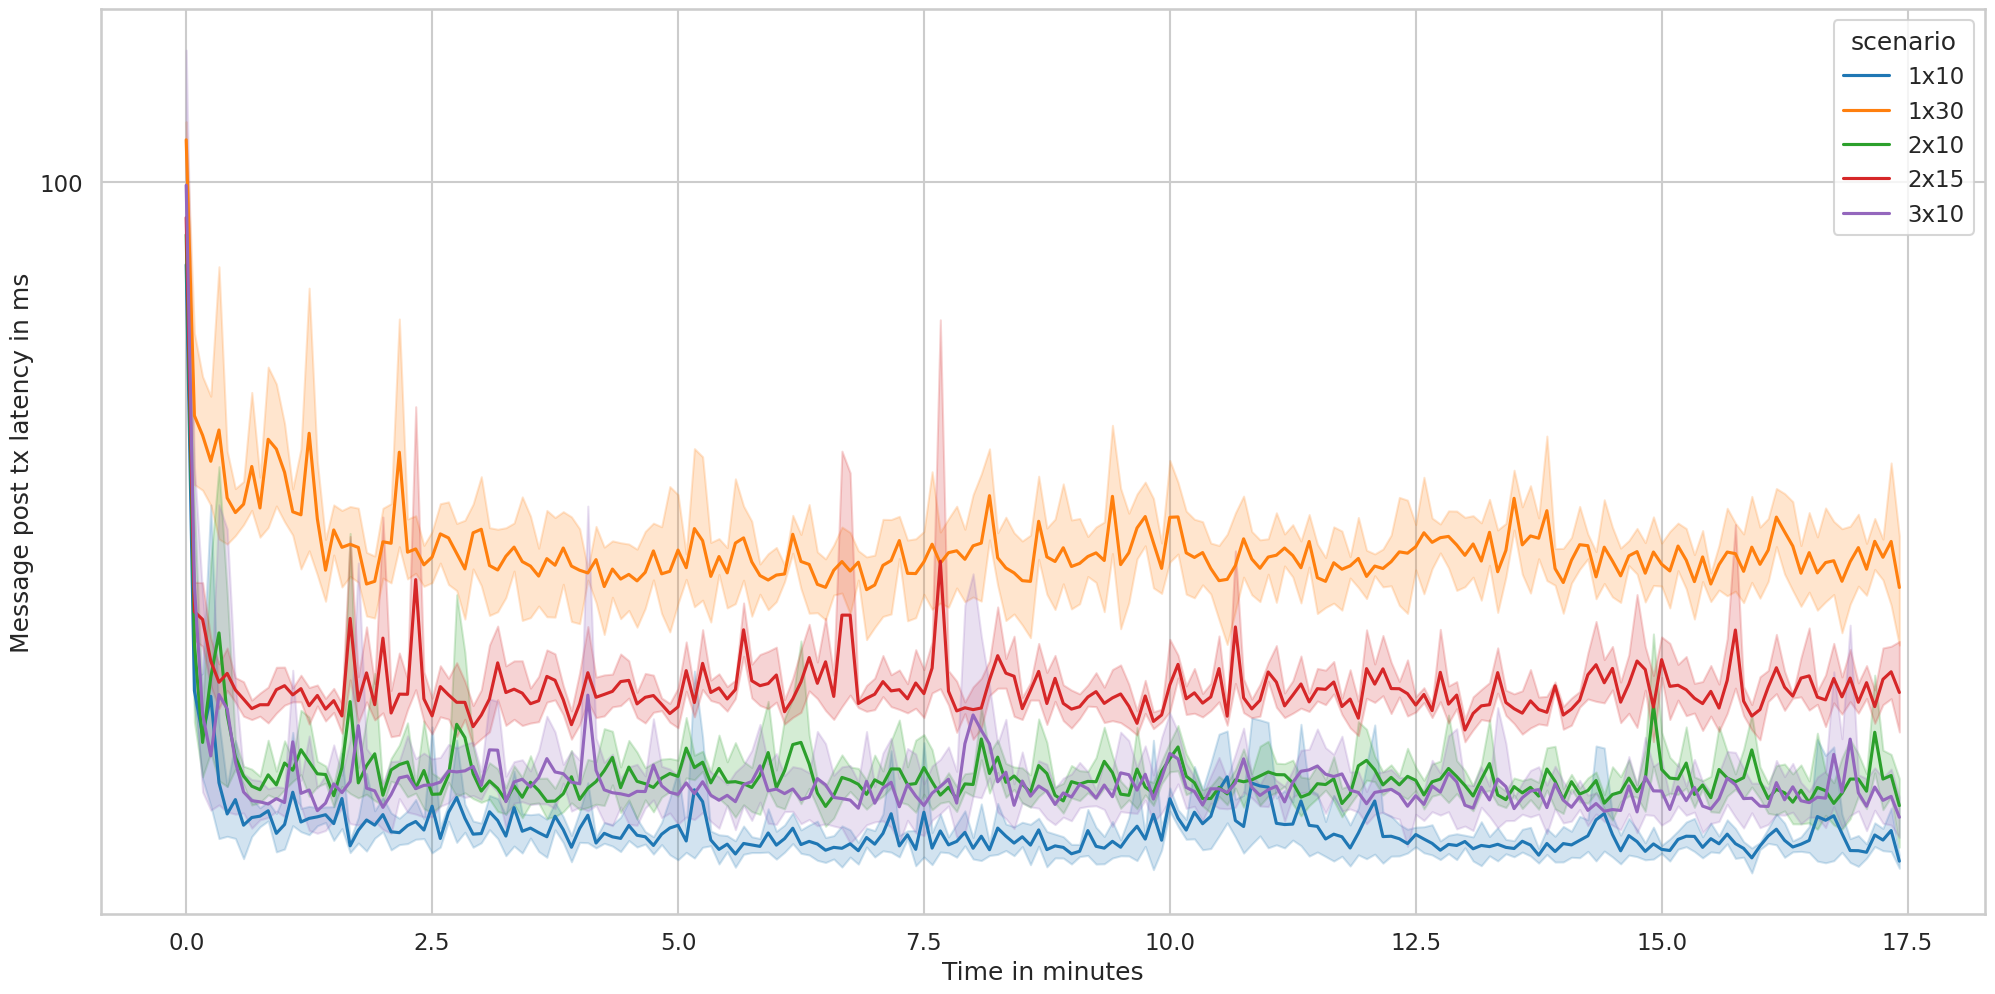

In [16]:
toot.post_tx(client_data_window)

2986824


13662
showing new plot: client_status_rx_latency


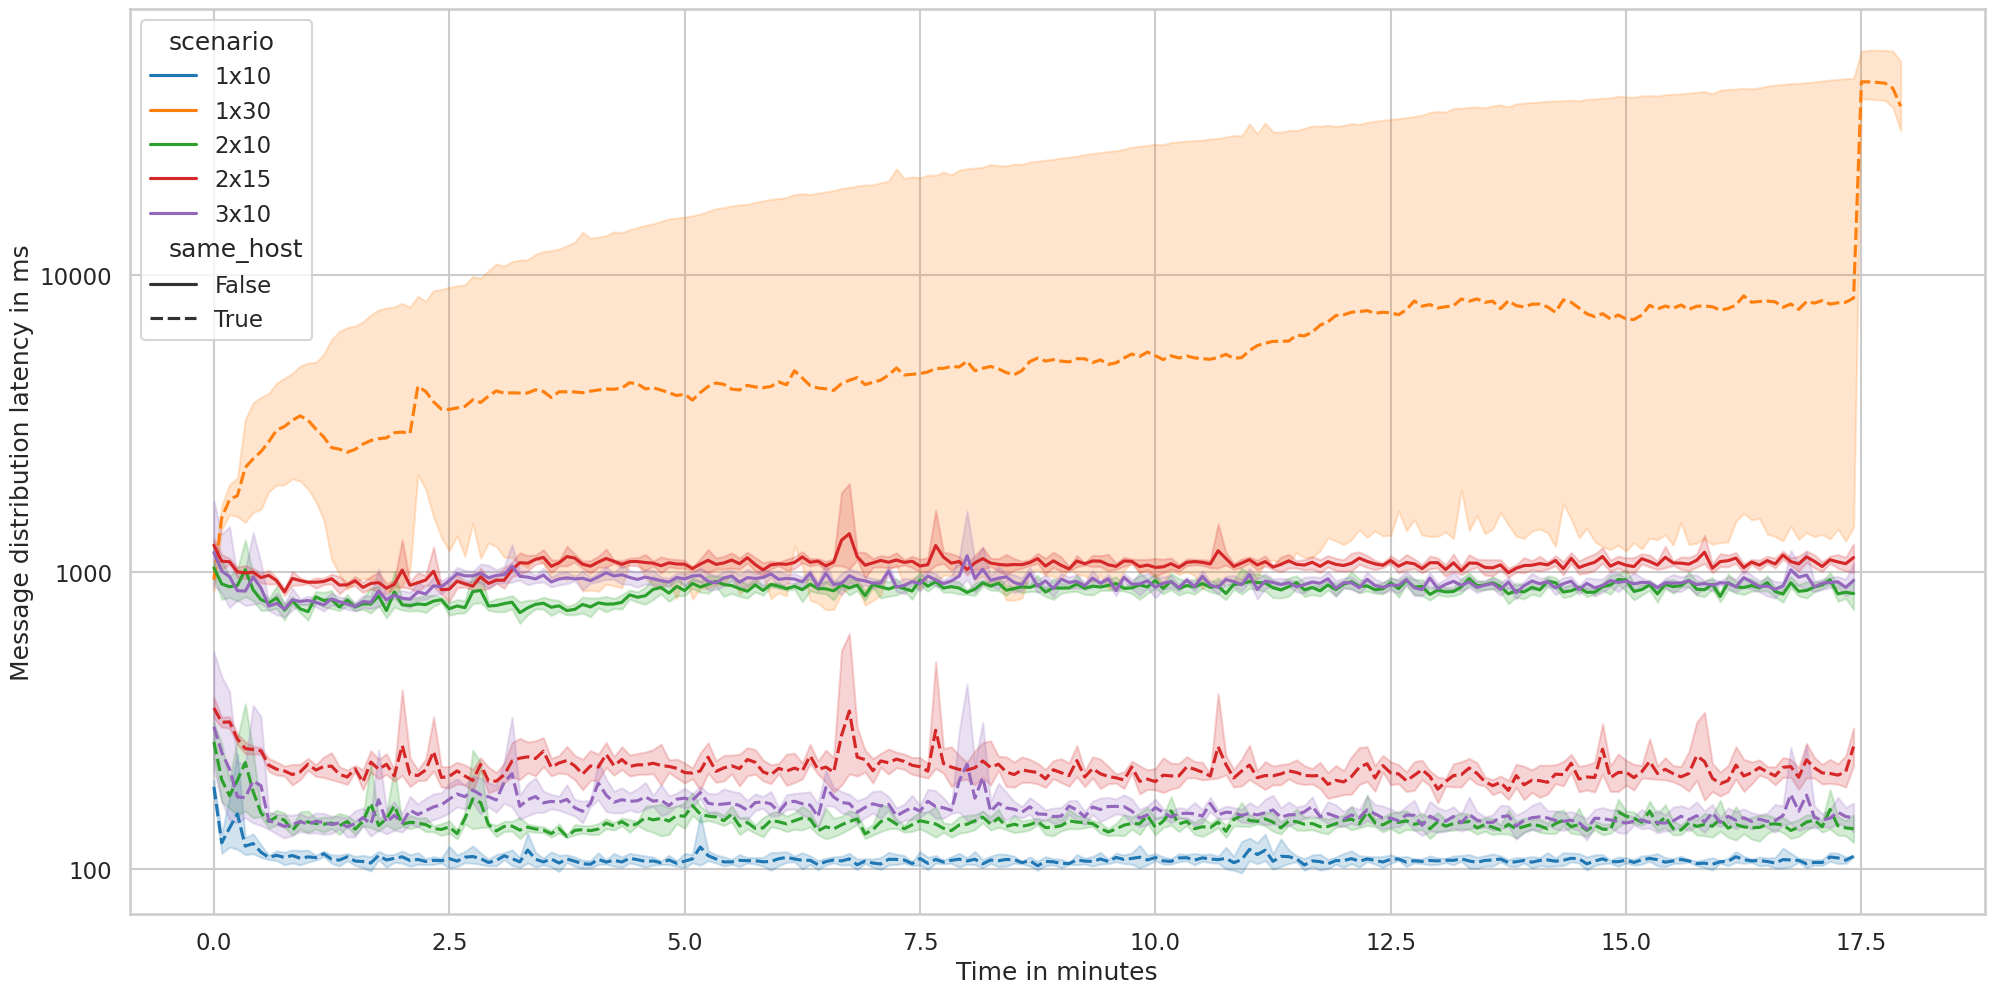

In [17]:
toot.post_rx(client_data_window)

2986824


13662
showing new plot: client_post_txack_latency


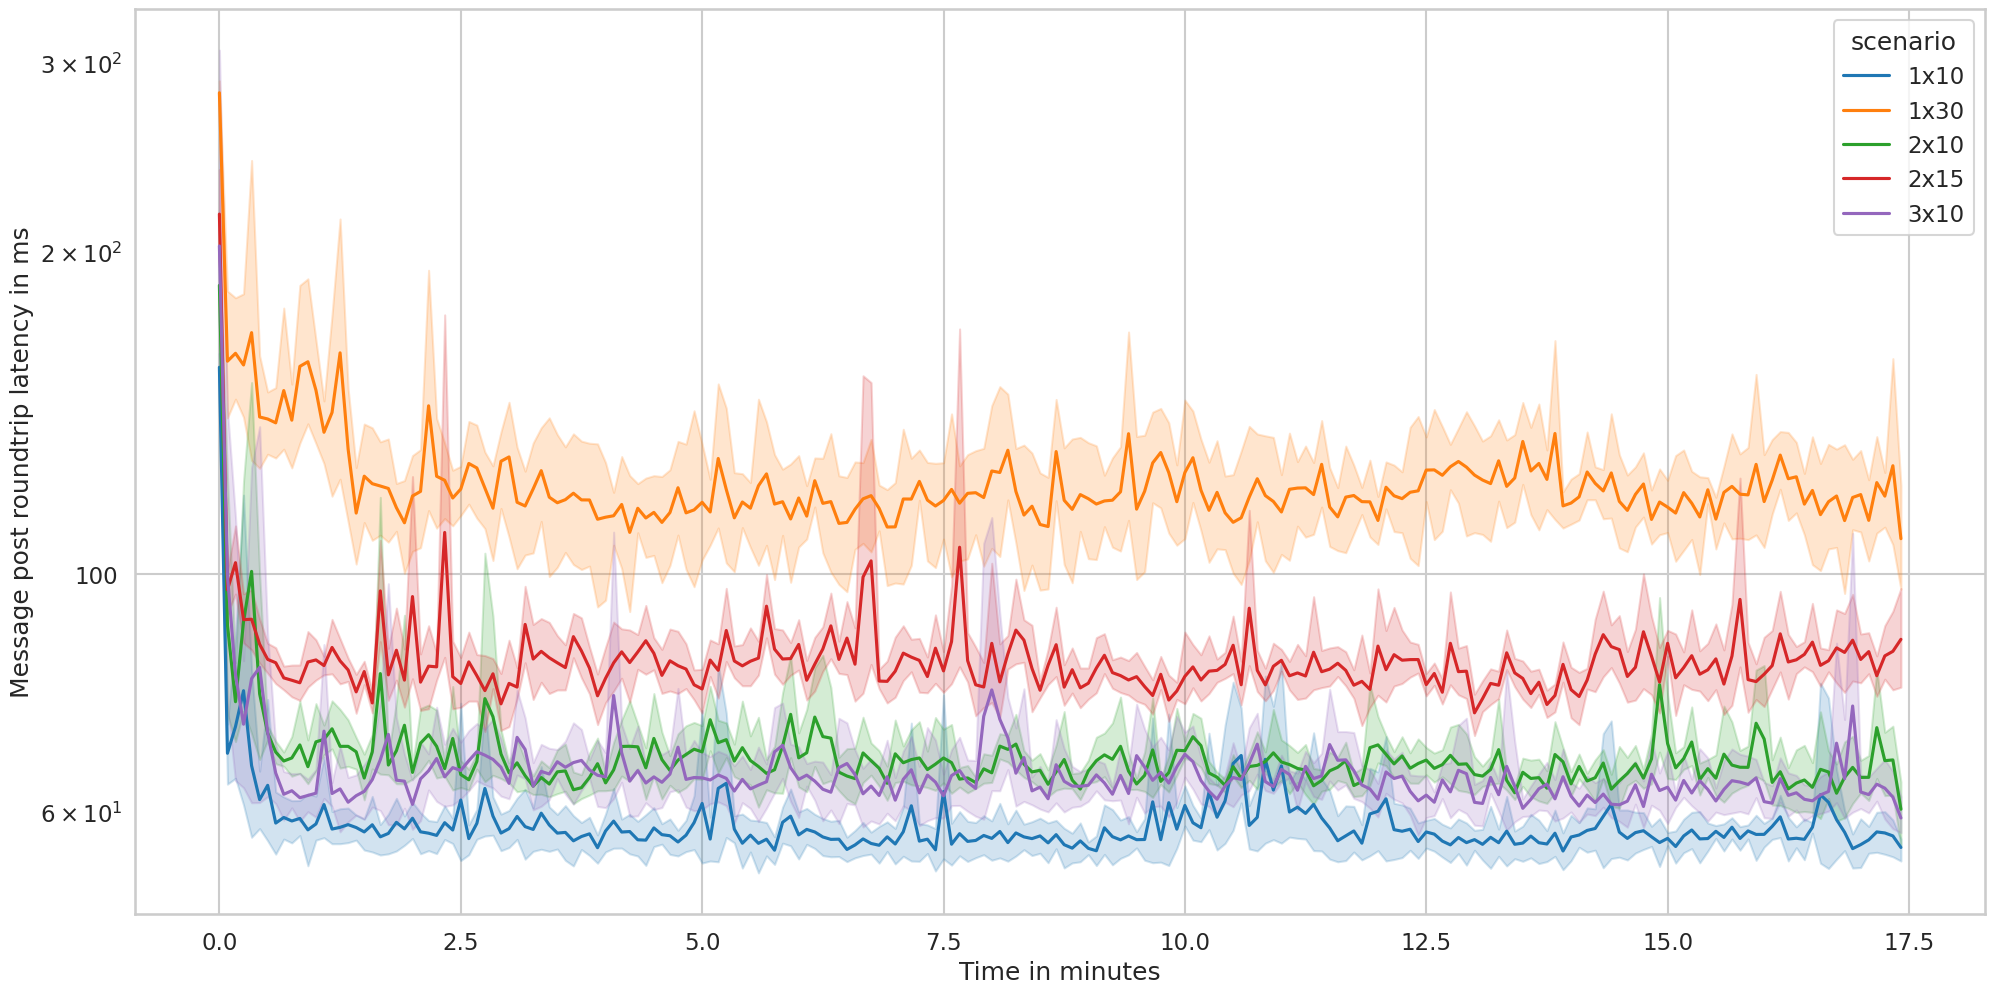

In [18]:
toot.post_txack(client_data_window)

## Other statistics

In [6]:
mp = Mpstat(folder, False)
dio = DiskIO(folder, False)
io = CpuIO(folder, False)

initializing vmstat
initialized. vmstat
initializing mpstat
initialized. mpstat
initializing iostat-disk
initialized. iostat-disk
initializing iostat-cpu
initialized. iostat-cpu
initializing ping
initialized. ping
initializing tootbench
initialized. tootbench


In [7]:
df = filter.of(client_data_window, filter.column("message_type", value="status"))(toot.df)
df

2986824
13662


time_delta scenario  run message_type  same_host  message_len  \
1        0.000000     1x10    1       status       True        143.0   
3        0.000000     1x10    2       status       True        143.0   
5        0.000000     1x10    3       status       True        143.0   
7        0.000000     1x10    4       status       True        143.0   
9        0.000000     1x10    5       status       True        143.0   
...           ...      ...  ...          ...        ...          ...   
13657   17.833333     1x30    2       status       True        143.0   
13658   17.833333     1x30    3       status       True        143.0   
13659   17.916667     1x30    1       status       True        143.0   
13660   17.916667     1x30    2       status       True        143.0   
13661   17.916667     1x30    3       status       True        143.0   

           delta_tx   delta_txack  
1        194.827069    194.382022  
3        194.717700    194.261364  
5        205.518629    205.105882  
7        174.850724    174.411111  
9        177.768016    177.288889  
...             ...           ...  
13657  36772.604866  36772.121339  
13658  37115.566092  37115.076687  
13659  52589.464253  52589.000000  
13660  30712.419669  30712.000000  
13661  31640.729697  31640.277778  

[8415 rows x 8 columns]

In [11]:
df.groupby(by=["scenario", "message_type", "same_host"], as_index=False).min()

scenario message_type  same_host  time_delta  run  message_len    delta_tx  \
0     1x10       status       True         0.0    1        143.0   93.306527   
1     1x30       status       True         0.0    1        143.0  260.591375   
2     2x10       status      False         0.0    1        143.0  639.770676   
3     2x10       status       True         0.0    1        143.0  114.054869   
4     2x15       status      False         0.0    1        143.0  734.429339   
5     2x15       status       True         0.0    1        143.0  151.771412   
6     3x10       status      False         0.0    1        143.0  663.034686   
7     3x10       status       True         0.0    1        143.0  116.420434   

   delta_txack  
0    92.808989  
1   260.114815  
2   639.282353  
3   113.566474  
4   733.943210  
5   151.266827  
6   662.547541  
7   115.929889

In [12]:
df.groupby(by=["scenario", "message_type", "same_host"], as_index=False).mean()

scenario message_type  same_host  time_delta       run  message_len  \
0     1x10       status       True    8.691714  2.997137        143.0   
1     1x30       status       True    8.860019  2.983146        143.0   
2     2x10       status      False    8.708333  3.000000        143.0   
3     2x10       status       True    8.700032  3.000953        143.0   
4     2x15       status      False    8.708333  3.000000        143.0   
5     2x15       status       True    8.708333  3.000000        143.0   
6     3x10       status      False    8.708333  3.000000        143.0   
7     3x10       status       True    8.708333  3.000000        143.0   

       delta_tx   delta_txack  
0    108.533421    108.044627  
1  15330.739560  15330.248208  
2    869.821686    869.331968  
3    145.403999    144.914805  
4   1057.532861   1057.042904  
5    221.641072    221.150401  
6    924.384700    923.890300  
7    162.492158    161.998389

In [13]:
df.groupby(by=["scenario", "message_type", "same_host"], as_index=False).max()

scenario message_type  same_host  time_delta  run  message_len  \
0     1x10       status       True   17.416667    5        143.0   
1     1x30       status       True   17.916667    5        143.0   
2     2x10       status      False   17.416667    5        143.0   
3     2x10       status       True   17.416667    5        143.0   
4     2x15       status      False   17.416667    5        143.0   
5     2x15       status       True   17.416667    5        143.0   
6     3x10       status      False   17.416667    5        143.0   
7     3x10       status       True   17.416667    5        143.0   

       delta_tx   delta_txack  
0    381.434415    380.911111  
1  57360.114642  57359.633766  
2   1536.709635   1536.195402  
3    493.165787    492.683333  
4   2725.585424   2725.093671  
5   1071.016256   1070.554945  
6   2511.389187   2510.893805  
7    959.350359    958.836879

In [11]:
sent = filter.column("message_type", "post")(toot.df)


In [12]:
toot.df.groupby(by=["scenario", "run", "message_type"]).count()

timestamp_iso  sender_username  message_timestamp  \
scenario run message_type                                                      
1x10     1   post                    802              802                802   
             status                 8020             8020               8020   
         2   post                    802              802                802   
             status                 8020             8020               8020   
         3   post                    802              802                802   
             status                 8020             8020               8020   
         4   post                    802              802                802   
             status                 8020             8020               8020   
         5   post                    802              802                802   
             status                 8020             8020               8020   
1x30     1   post                   2380             2380               2380   
             status                31997            31997              31997   
         2   post                   2375             2375               2375   
             status                32149            32149              32149   
         3   post                   2371             2371               2371   
             status                32241            32241              32241   
         4   post                   2375             2375               2375   
             status                32366            32366              32366   
         5   post                   2378             2378               2378   
             status                32288            32288              32288   
2x10     1   post                   1606             1606               1606   
             status                32120            32120              32120   
         2   post                   1609             1609               1609   
             status                32180            32180              32180   
         3   post                   1602             1602               1602   
             status                32040            32040              32040   
         4   post                   1605             1605               1605   
             status                32100            32100              32100   
         5   post                   1599             1599               1599   
             status                32000            32000              32000   
2x15     1   post                   2390             2390               2390   
             status                69842            69842              69842   
         2   post                   2383             2383               2383   
             status                69078            69078              69078   
         3   post                   4773             4773               4773   
             status               137629           137629             137629   
         4   post                   2394             2394               2394   
             status                68911            68911              68911   
         5   post                   2396             2396               2396   
             status                69139            69139              69139   
3x10     1   post                   2402             2402               2402   
             status                48922            48922              48922   
         2   post                   2396             2396               2396   
             status                48801            48801              48801   
         3   post                   2400             2400               2400   
             status                72000            72000              72000   
         4   post                   2407             2407               2407   
             status                49024            49024              49024   
         5   post          

In [10]:
docker.df.groupby(by=["scenario", "run", "host", "process", "container_id", "name", "timestamp"]).mean()


cpu_pct  \
scenario    run host    process        container_id name             timestamp               
debug_multi 1   debug-0 docker[68701]: 0b764e5d73fc mastodon-mail-1  1.675737e+09     0.00   
                                                                     1.675737e+09     0.00   
                                                                     1.675737e+09    62.93   
                                                                     1.675737e+09    62.93   
                                                                     1.675737e+09    34.49   
...                                                                                    ...   
                debug-1 docker[68989]: ef8e5f87dcb6 mastodon-redis-1 1.675739e+09     4.12   
                                                                     1.675739e+09     4.12   
                                                                     1.675739e+09     3.79   
                                                                     1.675739e+09     3.79   
                                                                     1.675739e+09     3.79   

                                                                                   mem_usage  \
scenario    run host    process        container_id name             timestamp                 
debug_multi 1   debug-0 docker[68701]: 0b764e5d73fc mastodon-mail-1  1.675737e+09   0.007843   
                                                                     1.675737e+09   0.007843   
                                                                     1.675737e+09   0.029521   
                                                                     1.675737e+09   0.029521   
                                                                     1.675737e+09   0.037314   
...                                                                                      ...   
                debug-1 docker[68989]: ef8e5f87dcb6 mastodon-redis-1 1.675739e+09   0.027490   
                                                                     1.675739e+09   0.027490   
                                                                     1.675739e+09   0.027568   
                                                                     1.675739e+09   0.027568   
                                                                     1.675739e+09   0.027568   

                                                                                   mem_limit  \
scenario    run host    process        container_id name             timestamp                 
debug_multi 1   debug-0 docker[68701]: 0b764e5d73fc mastodon-mail-1  1.675737e+09   0.000007   
                                                                     1.675737e+09   0.000007   
                                                                     1.675737e+09   0.000007   
                                                                     1.675737e+09   0.000007   
                                                                     1.675737e+09   0.000007   
...                                                                                      ...   
                debug-1 docker[68989]: ef8e5f87dcb6 mastodon-redis-1 1.675739e+09   0.000007   
                                                                     1.675739e+09   0.000007   
                                                                     1.675739e+09   0.000007   
                                                                     1.675739e+09   0.000007   
                                                                     1.675739e+09   0.000007   

                                                                                   mem_pct  \
scenario    run host    process        container_id name             timestamp               
debug_multi 1   debug-0 docker[68701]: 0b764e5d73fc mastodon-mail-1  1.675737e+09     0.10   
                                                                     1.675737e+0

---

# Bonus: Picasso creations

<AxesSubplot: xlabel='Time in seconds', ylabel='mem_pct'>

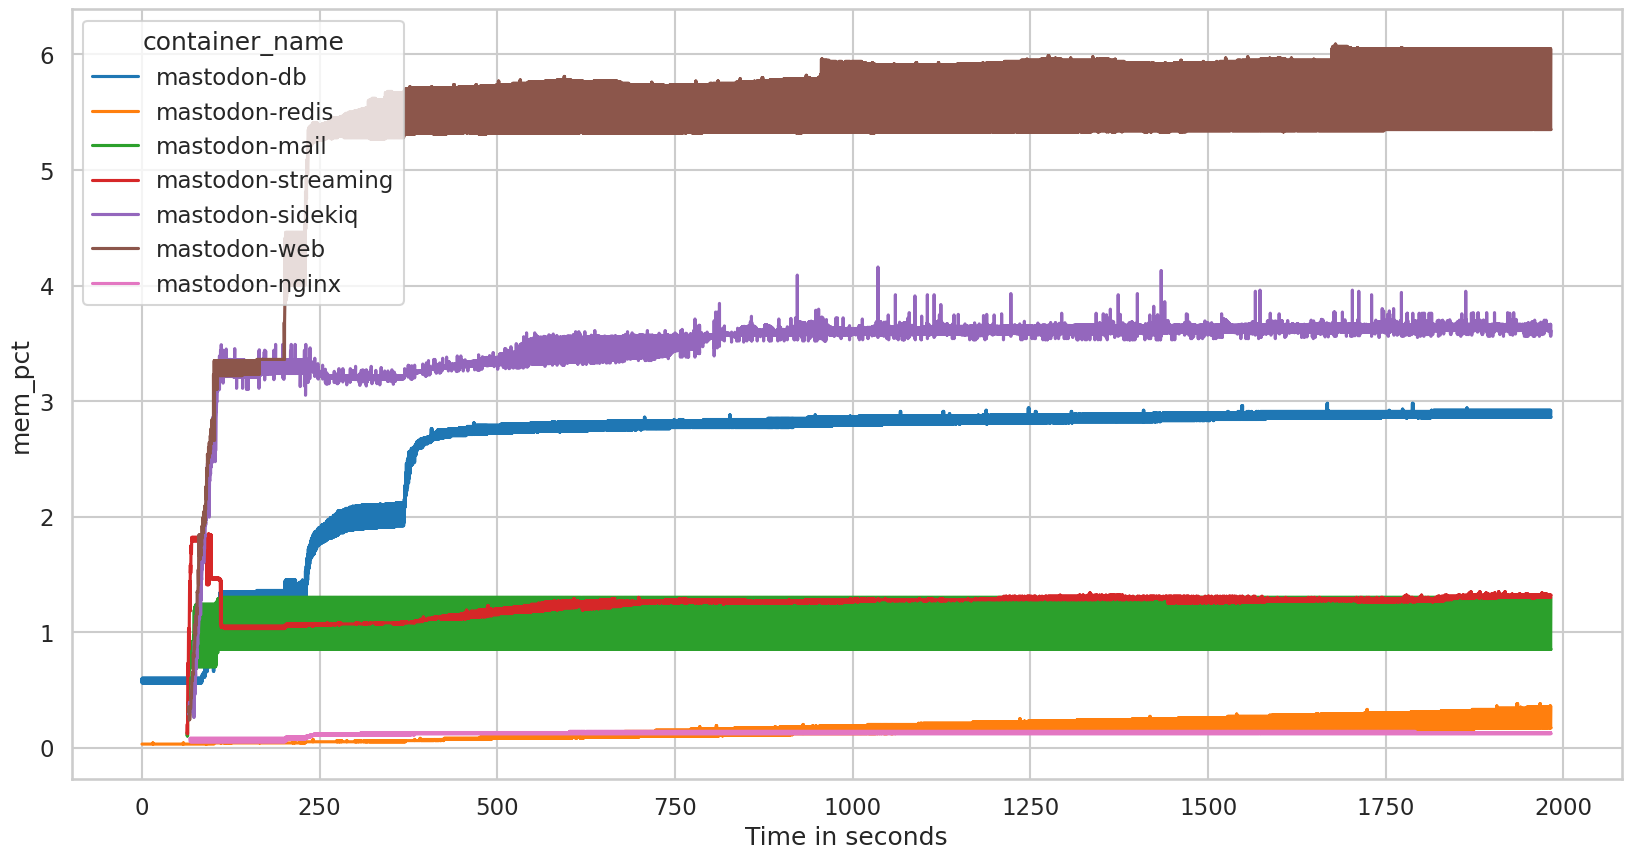

In [16]:
column="mem_pct"
fig, ax = plt.subplots(figsize=(20, 10), dpi=100)
ax.set_xlabel("Time in seconds")
ax.set_ylabel(column)
sb.lineplot(x="time", y=column, hue="container_name", data=docker.df_container, ax=ax)


<AxesSubplot: xlabel='Time in seconds', ylabel='net_input'>

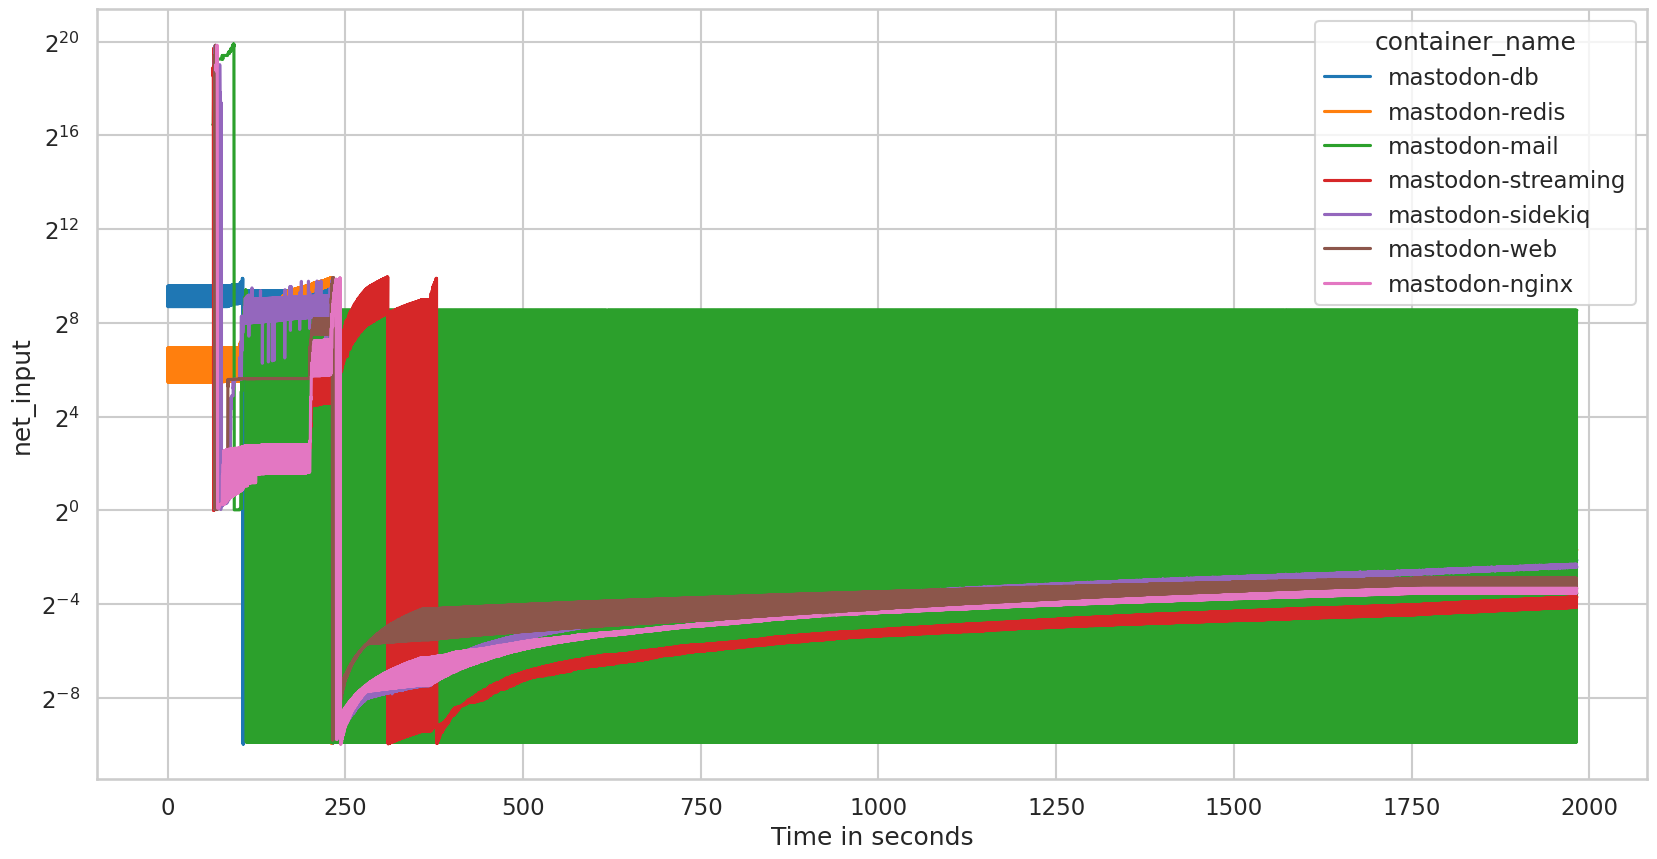

In [23]:
column="net_input"
fig, ax = plt.subplots(figsize=(20, 10), dpi=100)
ax.set_xlabel("Time in seconds")
ax.set_ylabel(column)
ax.set_yscale("log", base=10)
sb.lineplot(x="time", y=column, hue="container_name", data=docker.df_container, ax=ax)


<AxesSubplot: xlabel='Time in seconds', ylabel='net_output'>

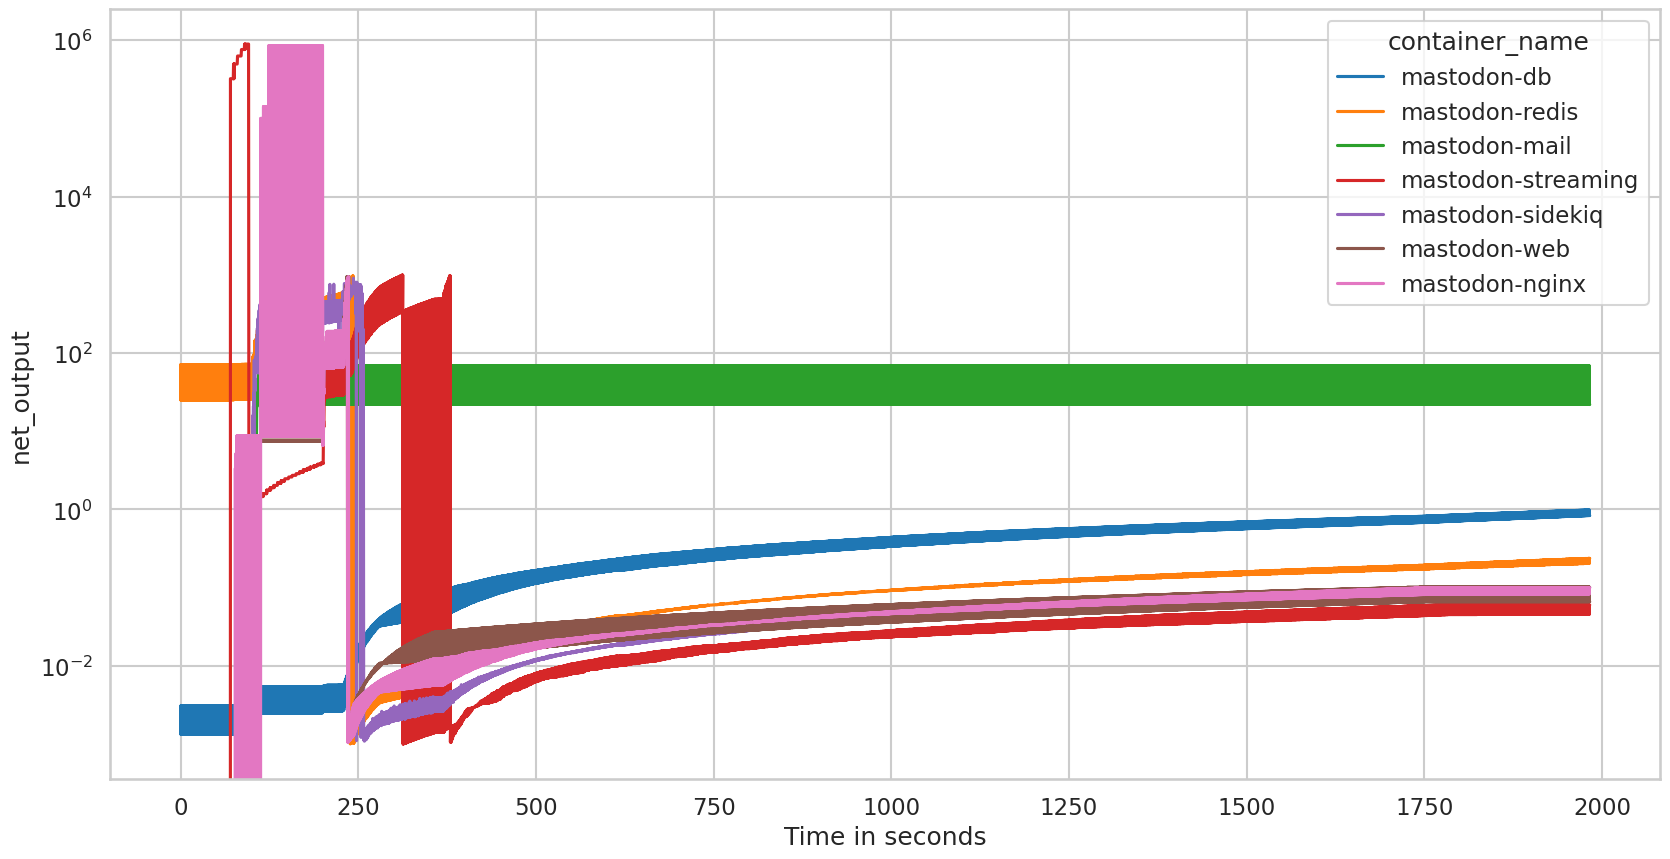

In [22]:
column="net_output"
fig, ax = plt.subplots(figsize=(20, 10), dpi=100)
ax.set_xlabel("Time in seconds")
ax.set_ylabel(column)
ax.set_yscale("log", base=10)
sb.lineplot(x="time", y=column, hue="container_name", data=docker.df_container, ax=ax)


<AxesSubplot: xlabel='Time in seconds', ylabel='block_input'>

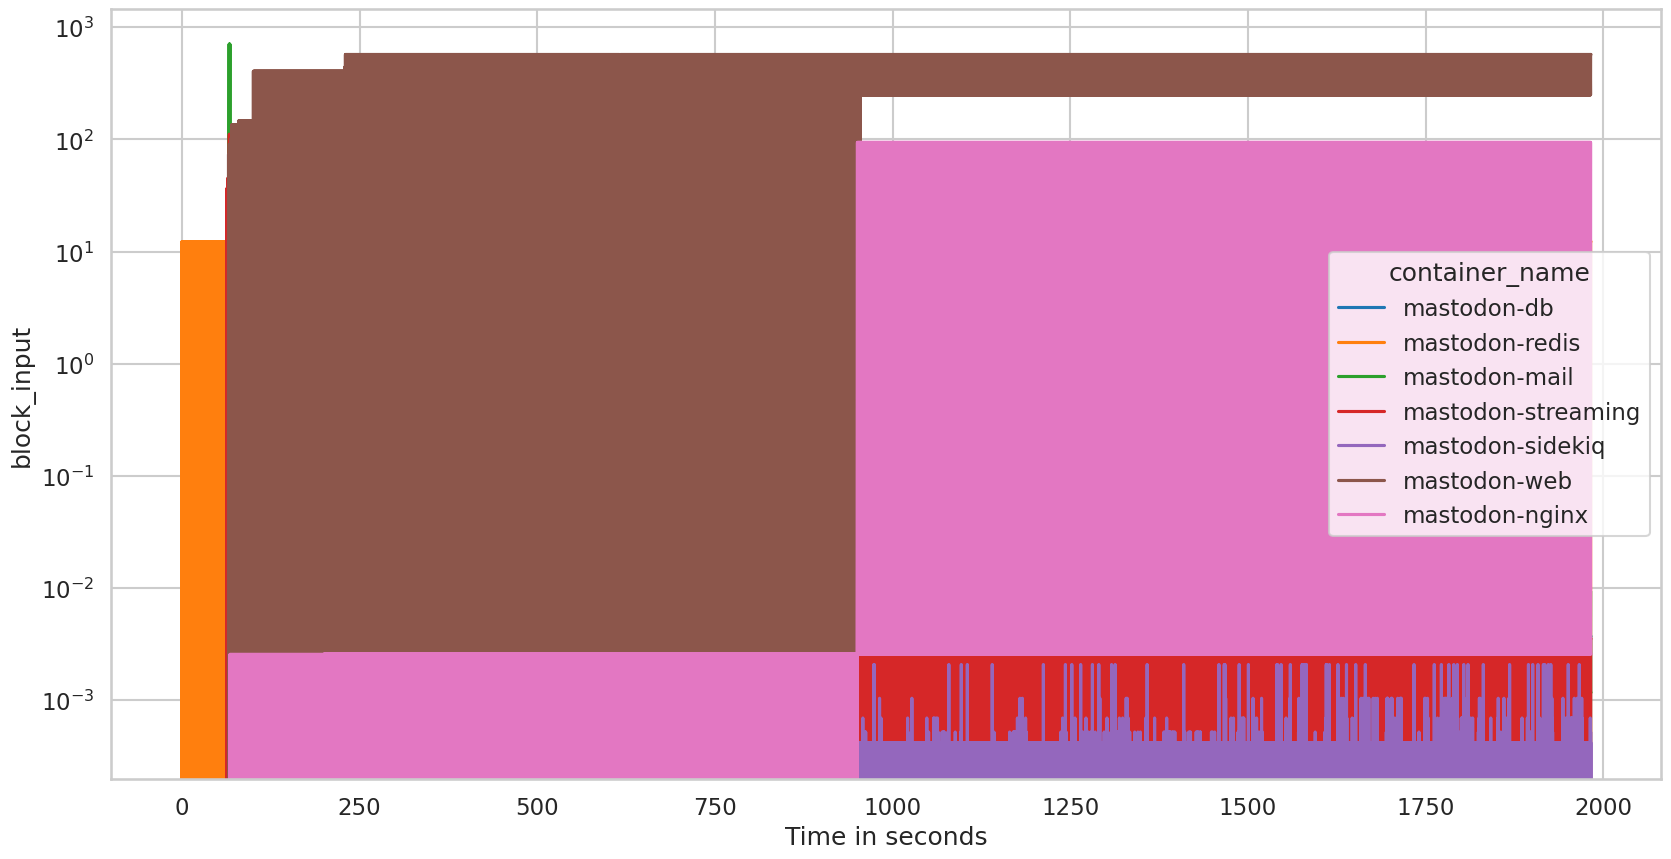

In [24]:
column="block_input"
fig, ax = plt.subplots(figsize=(20, 10), dpi=100)
ax.set_xlabel("Time in seconds")
ax.set_ylabel(column)
ax.set_yscale("log", base=10)
sb.lineplot(x="time", y=column, hue="container_name", data=docker.df_container, ax=ax)


<AxesSubplot: xlabel='Time in seconds', ylabel='block_output'>

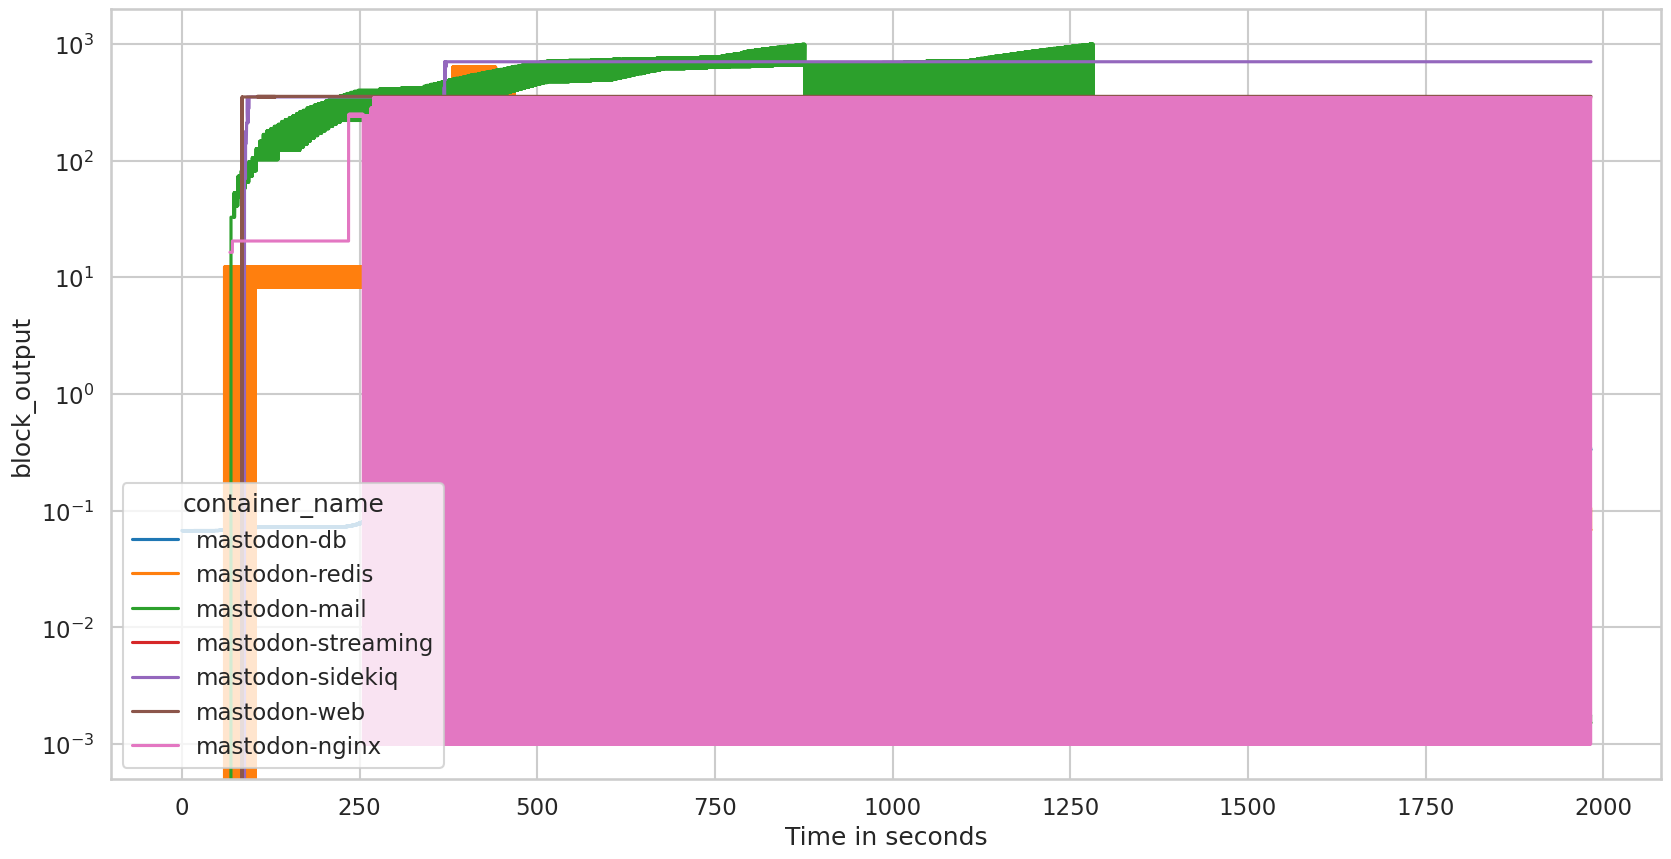

In [25]:
column="block_output"
fig, ax = plt.subplots(figsize=(20, 10), dpi=100)
ax.set_xlabel("Time in seconds")
ax.set_ylabel(column)


sb.lineplot(x="time", y=column, hue="container_name", data=docker.df_container, ax=ax)
